# Lecture 11: Variational Auto-Encoders

Notebook adapted from [Deep Learning (with Pytorch)](https://github.com/Atcold/pytorch-Deep-Learning) by Alfredo Canziani.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from matplotlib import pyplot as plt

/home/glouppe/anaconda3/envs/torch-gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# MNIST

In [3]:
tf = transforms.Compose([
    transforms.ToTensor(),
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./data", train=True, transform=tf),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./data", train=False, transform=tf),
    batch_size=256, shuffle=True)

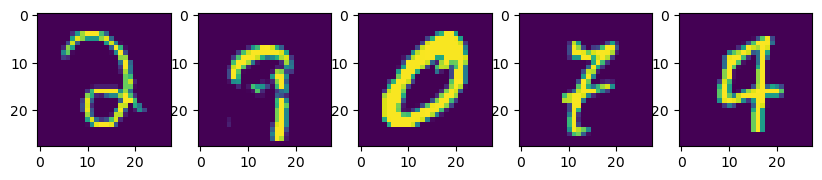

In [4]:
batch = next(iter(train_loader))
x = batch[0][:5]
y = batch[1][:5]

fig, axs = plt.subplots(1, 5, figsize=(10, 2))

for i in range(5):
    axs[i].imshow(x[i].squeeze().numpy())

# VAE

In [5]:
n_latent = 32

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, n_latent * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(n_latent, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 784),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, n_latent)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        eps = torch.randn(mu.shape).to(device)
        z = mu + (logvar.exp() ** 0.5) * eps
        return mu, logvar, z, self.decoder(z)

In [6]:
def train(model, optimizer):
    model.train()
    
    for x, _ in train_loader:
        x = x.to(device).view(-1, 784)

        # ELBO = E_p(eps)[log p(x | z=g(eps, x))] - KL(q(z | x) || p(z))
        optimizer.zero_grad()
        mu, logvar, z, x_hat = model(x)
        loss = F.binary_cross_entropy(x_hat, x, reduce=False).sum(axis=1).mean()
        loss += 0.5 * (mu ** 2 + logvar.exp() - logvar - 1).sum(axis=1).mean()
        loss.backward()            
        optimizer.step()
                
def test(model, epoch):
    model.eval()
    
    # Evaluate test loss
    test_loss = 0
    
    for x, _ in test_loader:
        x = x.to(device).view(-1, 784)
        mu, logvar, z, x_hat = model(x)
        loss = F.binary_cross_entropy(x_hat, x, reduce=False).sum()
        loss += 0.5 * (mu ** 2 + logvar.exp() - logvar - 1).sum()
        test_loss += loss 
        
    test_loss /= len(test_loader.dataset)
    print(f"epoch={epoch} test loss={test_loss:.4f}")
    
    # Show reconstructions
    batch = next(iter(test_loader))
    x = batch[0][:5].to(device)

    fig, axs = plt.subplots(2, 5, figsize=(10, 4))

    for i in range(5):
        axs[0, i].imshow(x[i].squeeze().cpu().numpy())
        
    _, _, _, x_hat = model(x)
    
    for i in range(5):
        axs[1, i].imshow(x_hat[i].view(28, 28).detach().cpu().numpy())
        
    plt.show()

/home/glouppe/anaconda3/envs/torch-gpu/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


epoch=0 test loss=544.4360


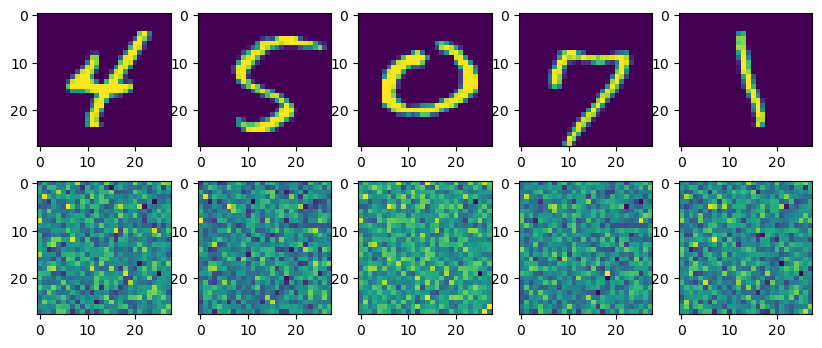

epoch=1 test loss=192.0177


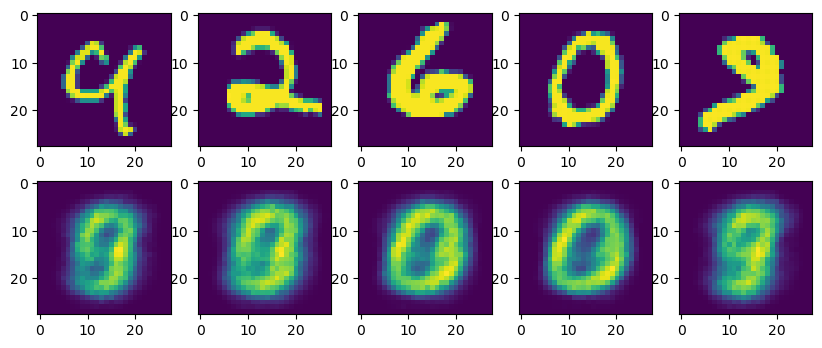

epoch=2 test loss=173.8834


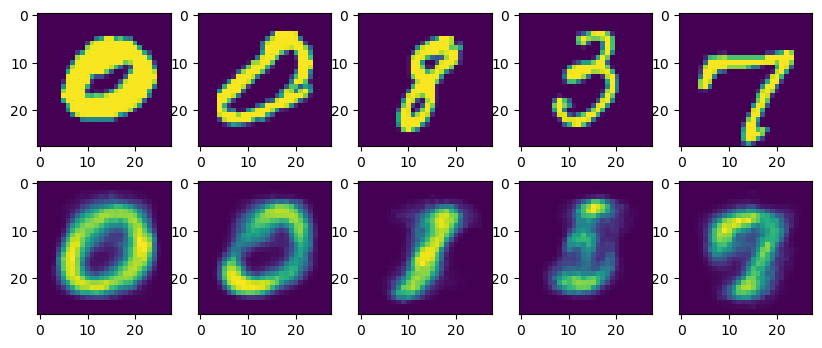

epoch=3 test loss=150.7904


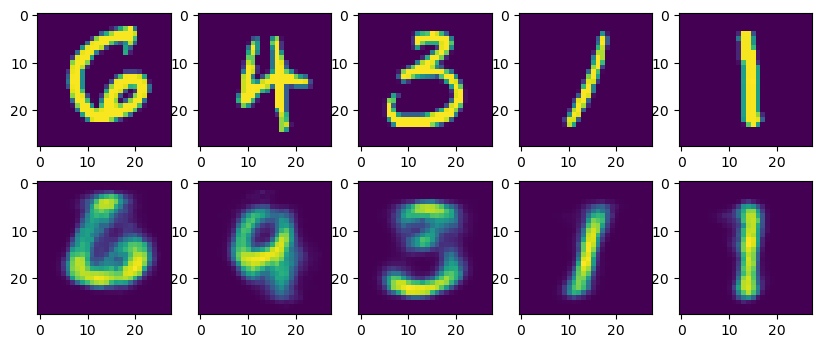

epoch=4 test loss=139.9463


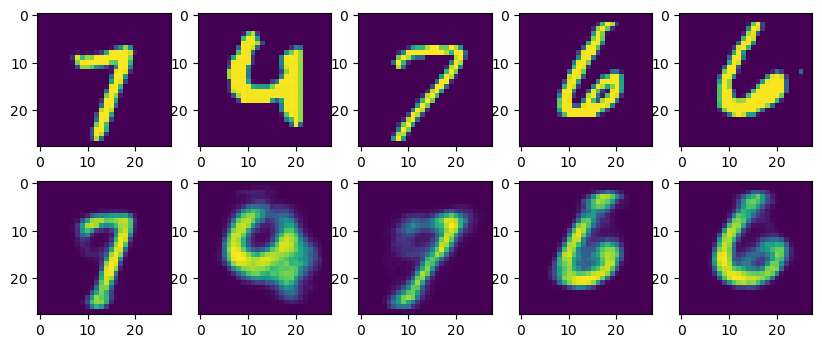

epoch=5 test loss=133.6503


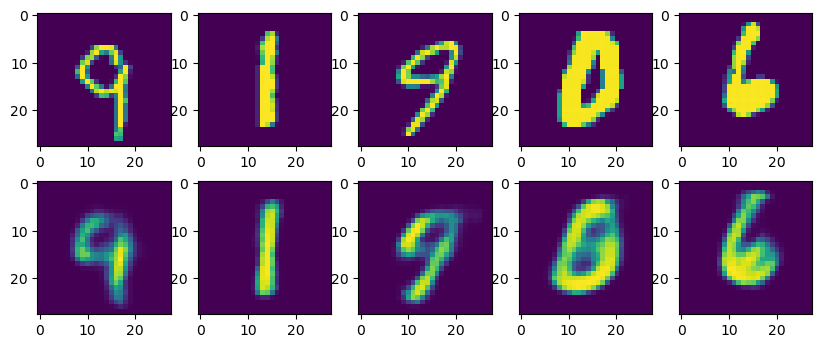

epoch=6 test loss=129.7534


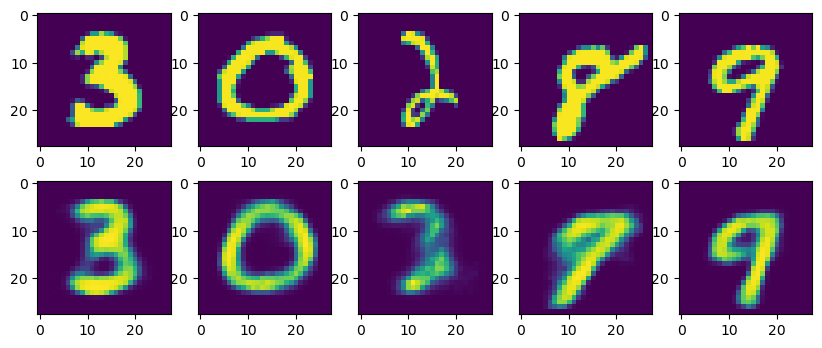

epoch=7 test loss=126.8948


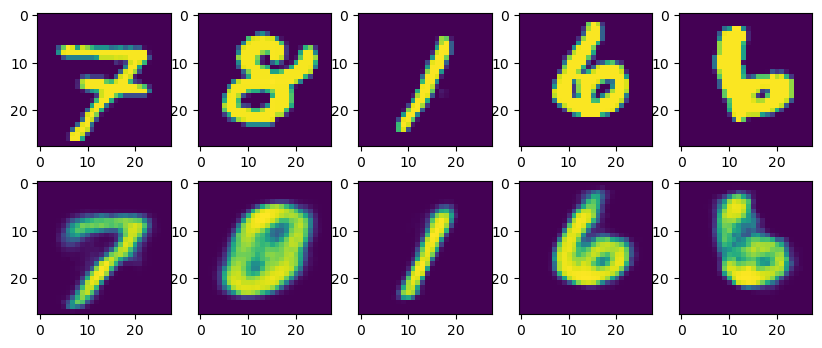

epoch=8 test loss=124.1297


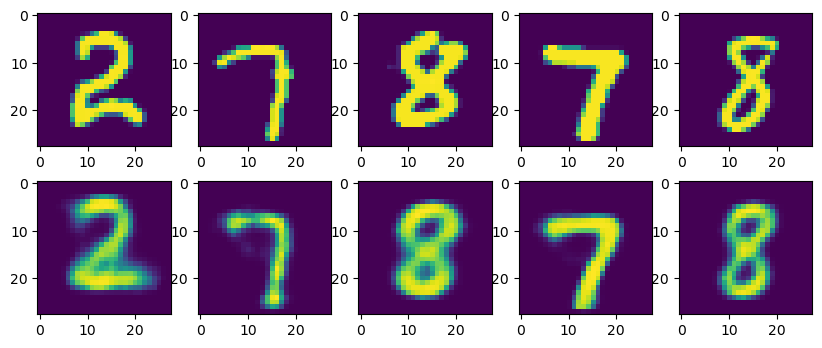

epoch=9 test loss=121.3158


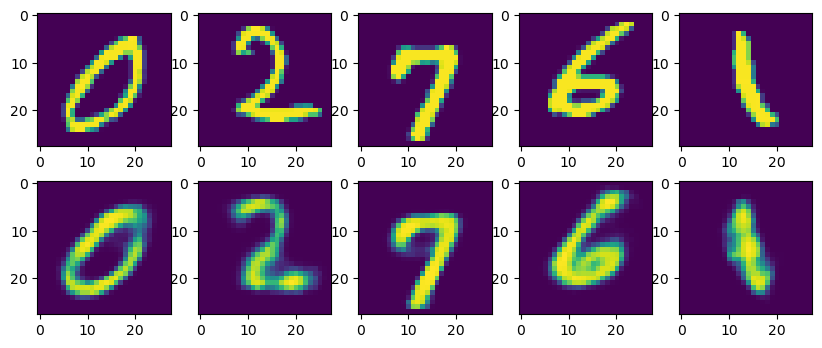

epoch=10 test loss=119.1099


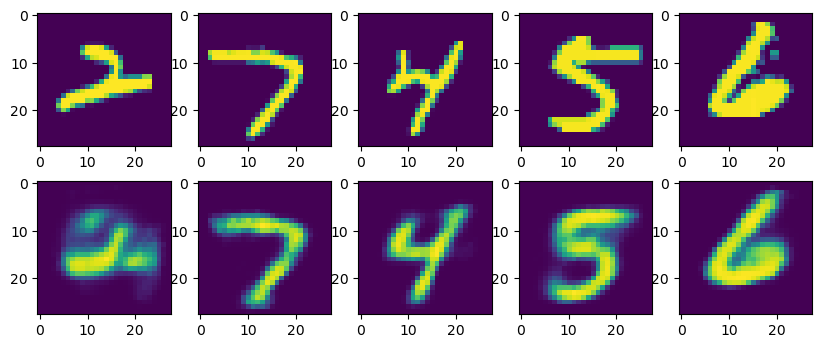

In [7]:
# Training
model = VAE().to(device)
optimizer = torch.optim.AdamW(model.parameters())

for epoch in range(10):
    test(model, epoch)
    train(model, optimizer)
    
test(model, epoch+1)

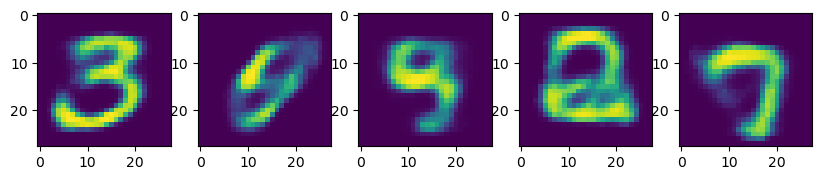

In [8]:
# Generating new samples
z = torch.randn(5, n_latent).to(device)
x_hat = model.decoder(z)

fig, axs = plt.subplots(1, 5, figsize=(10, 2))

for i in range(5):
    axs[i].imshow(x_hat[i].view(28, 28).detach().cpu().numpy())
    
plt.show()

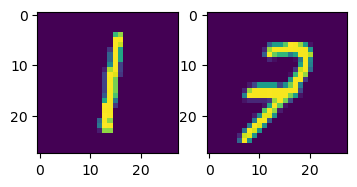

In [34]:
# Interpolation
batch = next(iter(test_loader))
x = batch[0][:10].to(device)
z = model.encoder(x.view(-1, 784))
mu = z[:, :n_latent]
a, b = 0, 1

fig, axs = plt.subplots(1, 2, figsize=(4, 2))
axs[0].imshow(x[a].squeeze().cpu().numpy())
axs[1].imshow(x[b].squeeze().cpu().numpy())   
plt.show()

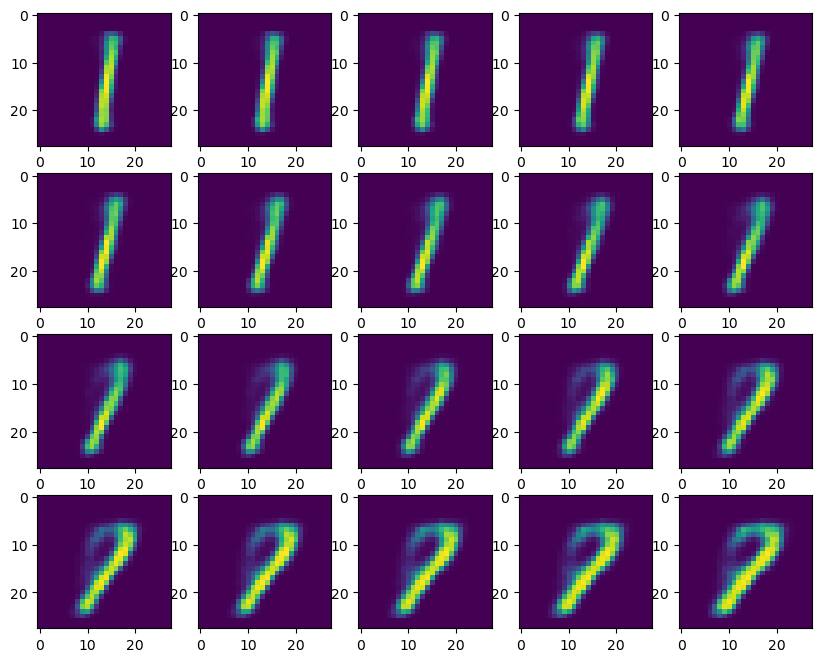

In [35]:
N = 20
z = torch.zeros(N, n_latent).to(device)

for i in range(N):
    z[i] = i / (N - 1) * mu[b] + (1 - i / (N - 1)) * mu[a]

x_hat = model.decoder(z)

fig, axs = plt.subplots(N // 5, 5, figsize=(10, 2 * (N // 5)))

for i in range(N // 5):
    for j in range(5):
        axs[i, j].imshow(x_hat[i*5+j].view(28, 28).detach().cpu().numpy())  
plt.show()

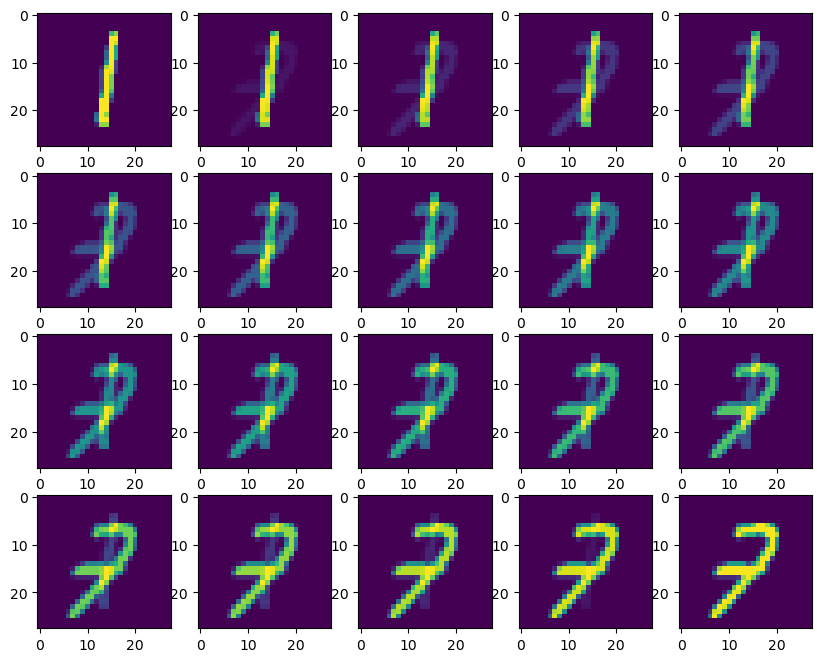

In [36]:
N = 20
x = x.view(-1, 784)
x_hat = torch.zeros(N, 784).to(device)

for i in range(N):
    x_hat[i] = i / (N - 1) * x[b] + (1 - i / (N - 1)) * x[a]

fig, axs = plt.subplots(N // 5, 5, figsize=(10, 2 * (N // 5)))

for i in range(N // 5):
    for j in range(5):
        axs[i, j].imshow(x_hat[i*5+j].view(28, 28).detach().cpu().numpy())  
plt.show()